# WorldCereal Embeddings Demo

This notebook demonstrates how to generate spatio-temporal WorldCereal embeddings through the openEO backend and visualize the resulting multiband GeoTIFF. The pretrained geospatial model under the hood is NASA Harvest's Presto model, finetuned on WorldCereal reference data.

**Workflow overview**:
1. Configure parameters for the embeddings generation.
2. Interactively select an Area of Interest (AOI) and processing date range.
3. Build and run the openEO process graph to create an asynchronous job.
4. Download the resulting embeddings GeoTIFF.
5. Inspect and visualize the embeddings (band statistics, PCA projection, pseudo-color rendering).

Use this as a starting point to explore model outputs or integrate embeddings into downstream ML tasks.

> Tip: Keep your AOI modest in size initially to reduce processing time. Expand once the workflow is validated.

> Note: Maximum area for this processing is limited as larger areas may run into computational issues. If you want to run this at scale, openEO's job manager will be required.

In [7]:
# Core imports for building the WorldCereal embeddings process graph
from worldcereal.job import create_embeddings_process_graph
from worldcereal.parameters import EmbeddingsParameters

# Utility/visualization imports
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Raster I/O for visualization after download
import rasterio

OUTPUT_PATH = Path("worldcereal_embeddings.tif")

## 1. Configure Embedding Parameters

Adjust any parameters below to control the embedding generation. You can override (for example) the model URL or other processing options if exposed by the API. After instantiation we print the effective configuration for transparency.

In [2]:
# Instantiate embedding parameters (override defaults by passing arguments)
# Example: EmbeddingsParameters(presto_model_url="s3://bucket/custom_model.onnx")
embedding_params = EmbeddingsParameters()

# Display the resolved parameters (assumes dataclass / attrs-like repr)
print("Embedding Parameters:\n", embedding_params)

Embedding Parameters:
 feature_parameters=FeaturesParameters(rescale_s1=False, presto_model_url='https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-prometheo-landcover-month-LANDCOVER10-augment%3DTrue-balance%3DTrue-timeexplicit%3DFalse-run%3D202507170930_encoder.pt', compile_presto=False, temporal_prediction=False, target_date=None)


## 2. Select Area of Interest & Time Range

Use the interactive map below to draw/select your AOI. Then use the date slider to choose the processing period. Keep ranges short at first to speed up processing.

In [3]:
from worldcereal.utils.map import ui_map

# Launch interactive map (draw/select AOI)
map = ui_map(area_limit=400)  # To keep processing as a demo manageable
map

A key feature of WorldCereal is its dynamic nature to compute embeddings (and infer downstream classes) on dynamically chosen temporal windows, aligned to the seasonality of interest. We compute the embeddings based on a one-year time range that can be chosen below.

In [4]:
from notebook_utils.dateslider import date_slider

# Create interactive date range selector widget
slider = date_slider()
slider

### Capture Selected Extent & Period
Run the cell below after finalizing the AOI and dates to capture them for the openEO job.

In [5]:
# Retrieve AOI extent and date range
extent = map.get_extent()
processing_period = slider.get_selected_dates()

print("Extent (bbox or geometry):", extent)
print("Processing period:", processing_period)

2025-09-18 14:38:42.765 | INFO     | notebook_utils.dateslider:get_selected_dates:233 - Selected period: 2024-06-01 to 2025-05-31


Extent (bbox or geometry): BoundingBoxExtent(west=265985.5166884527, south=6242321.352307225, east=284581.218240116, north=6260649.753887329, epsg=32721)
Processing period: TemporalContext(start_date='2024-06-01', end_date='2025-05-31')


## 3. Run openEO Embeddings Job
This step builds the embeddings process graph, submits it as a job, waits for completion, and downloads the result as a multiband GeoTIFF.

In [6]:
from worldcereal.job import INFERENCE_JOB_OPTIONS

scale_uint16 = True  # If False, the original Float32 values are returned

# Create WorldCereal Embeddings openEO process graph
print("Building process graph...")
inference_result = create_embeddings_process_graph(
    spatial_extent=extent,
    temporal_extent=processing_period,
    embeddings_parameters=embedding_params,
    scale_uint16=scale_uint16,
)

# Create the job
print("Creating job...")
job = inference_result.create_job(
    title="WorldCereal Embeddings Map",
    job_options=INFERENCE_JOB_OPTIONS,
)

# Start and wait
print("Starting job (this may take a while depending on AOI & cluster load)...")
job.start_and_wait()
print("Job finished. Retrieving results...")

# Download first GeoTIFF asset
for asset in job.get_results().get_assets():
    if asset.metadata.get("type", "").startswith("image/tiff"):
        print(f"Downloading asset to {OUTPUT_PATH} ...")
        asset.download(str(OUTPUT_PATH))
        break
else:
    raise RuntimeError("No GeoTIFF asset found in job results.")

if not OUTPUT_PATH.exists():
    raise FileNotFoundError(f"Expected output not found: {OUTPUT_PATH}")
print("Download complete.")

Building process graph...
Authenticated using refresh token.


2025-09-18 14:39:23,240 - openeo_gfmap.utils - INFO - Selected orbit state: DESCENDING. Reason: Only orbit fully covering the requested area.


Creating job...
Starting job (this may take a while depending on AOI & cluster load)...
0:00:00 Job 'j-250918123924422e9c13a4f37fc568b8': send 'start'
0:00:18 Job 'j-250918123924422e9c13a4f37fc568b8': created (progress 0%)
0:00:23 Job 'j-250918123924422e9c13a4f37fc568b8': created (progress 0%)
0:00:30 Job 'j-250918123924422e9c13a4f37fc568b8': created (progress 0%)
0:00:38 Job 'j-250918123924422e9c13a4f37fc568b8': created (progress 0%)
0:00:48 Job 'j-250918123924422e9c13a4f37fc568b8': queued (progress 0%)
0:01:01 Job 'j-250918123924422e9c13a4f37fc568b8': queued (progress 0%)
0:01:16 Job 'j-250918123924422e9c13a4f37fc568b8': queued (progress 0%)
0:01:35 Job 'j-250918123924422e9c13a4f37fc568b8': queued (progress 0%)
0:01:59 Job 'j-250918123924422e9c13a4f37fc568b8': queued (progress 0%)
0:02:29 Job 'j-250918123924422e9c13a4f37fc568b8': queued (progress 0%)
0:03:08 Job 'j-250918123924422e9c13a4f37fc568b8': running (progress N/A)
0:03:56 Job 'j-250918123924422e9c13a4f37fc568b8': running (pro

## 4. Inspect & Visualize Embeddings
We now load the downloaded multiband embeddings GeoTIFF and produce:
1. Per-band value distribution (histogram)
2. PCA projection (first 3 components) rendered as an RGB image
3. Optional pseudo-color rendering from selected bands

Note: If data were scaled to UInt16, we scale back first to the original Float32 values.

In [ ]:
# Open the embeddings raster and inspect basic metadata
with rasterio.open(OUTPUT_PATH) as ds:
    data = ds.read()  # shape: (bands, height, width)
    profile = ds.profile

# Go back to original scale if needed
if scale_uint16:
    # Empirically determined scaling factors for Presto-based WorldCereal embeddings
    offset = -6
    scale = 0.0002
    data = data.astype(np.float32) * scale + offset

print("Raster profile:\n", profile)
print("Data shape (bands, height, width):", data.shape)

Raster profile:
 {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 1861, 'height': 1833, 'count': 128, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 21S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32721"]]'), 'transform': Affine(10.0, 0.0, 265980.0,
       0.0, -10.0, 6260650.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
Data shape (bands, height, width): (128, 1833, 1861)


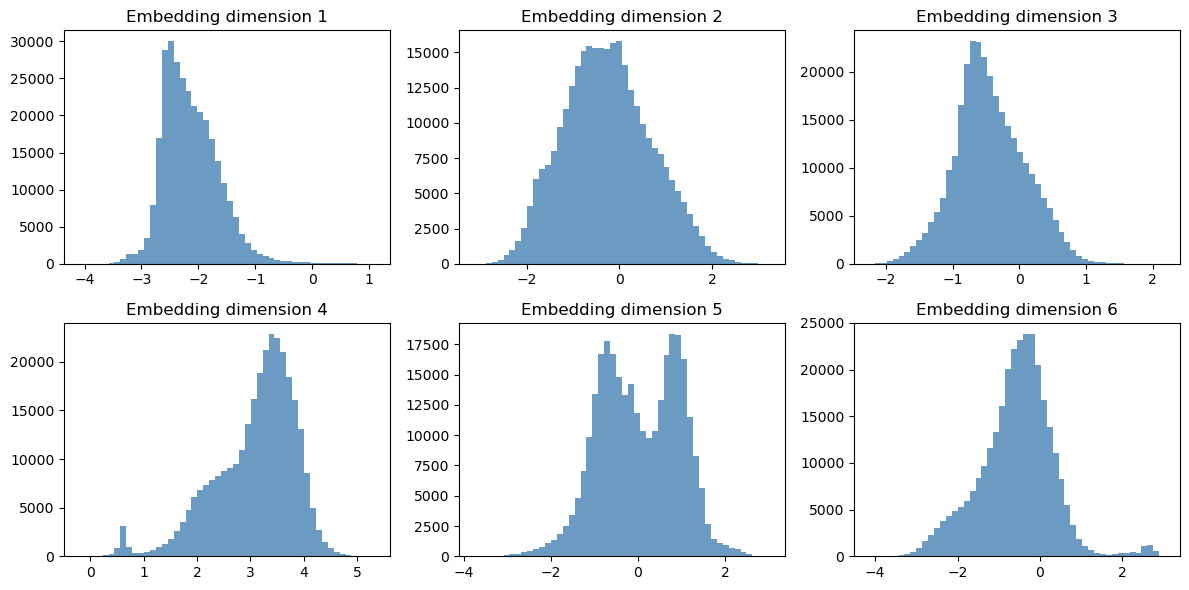

In [18]:
# Plot histograms for first few embeddings
bands_to_plot = min(6, data.shape[0])
fig, axes = plt.subplots(2, (bands_to_plot+1)//2, figsize=(12, 6))
axes = axes.flatten()
for i in range(bands_to_plot):
    arr = data[i].ravel()
    sample = arr if arr.size < 300_000 else np.random.choice(arr, 300_000, replace=False)
    axes[i].hist(sample, bins=50, color='steelblue', alpha=0.8)
    axes[i].set_title(f'Embedding dimension {i+1}')
plt.tight_layout()
plt.show()

In [19]:
# Incremental / chunked PCA to avoid memory blow-ups
import numpy as np
from sklearn.decomposition import IncrementalPCA

bands, h, w = data.shape
flat = data.reshape(bands, -1).T  # (pixels, bands)

# Configuration
n_components = 3
fit_sample_max = 400_000   # subset used to fit
chunk_size = 50_000        # number of pixels processed per partial_fit / transform

n_pixels = flat.shape[0]
idx_all = np.arange(n_pixels)

# Select subset for fitting (random) to speed up & reduce RAM
if n_pixels > fit_sample_max:
    fit_idx = np.random.choice(n_pixels, fit_sample_max, replace=False)
else:
    fit_idx = idx_all

ipca = IncrementalPCA(n_components=n_components)

# Pass 1: partial_fit on chunks of the fit subset
for start in range(0, fit_idx.size, chunk_size):
    end = start + chunk_size
    batch_idx = fit_idx[start:end]
    ipca.partial_fit(flat[batch_idx])

print('Explained variance ratio (incremental):', ipca.explained_variance_ratio_)

Explained variance ratio (incremental): [0.35388869 0.12722274 0.11828975]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


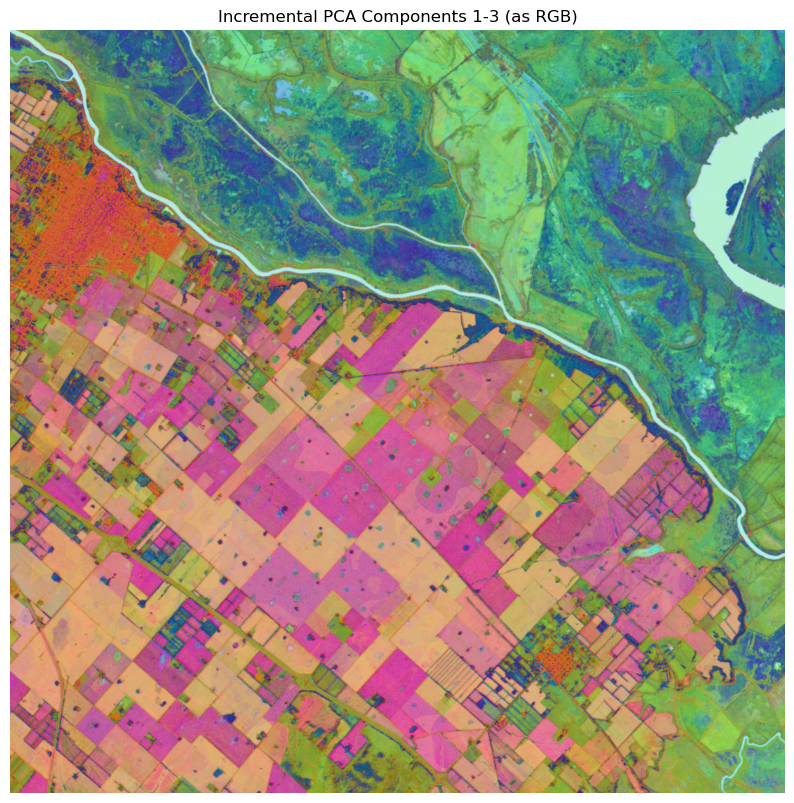

Final component ranges: [(-10.917854454079796, 8.413067937374352), (-9.62177069065738, 8.502082002994708), (-8.596642278485387, 10.682263330758223)]


In [ ]:
# Pass 2: transform entire image in chunks (streaming) and track per-component min/max
components_full = np.empty((n_pixels, ipca.n_components), dtype=np.float32)
comp_min = np.full(ipca.n_components, np.inf, dtype=np.float64)
comp_max = np.full(ipca.n_components, -np.inf, dtype=np.float64)

for start in range(0, n_pixels, chunk_size):
    end = min(start + chunk_size, n_pixels)
    transformed = ipca.transform(flat[start:end])
    components_full[start:end] = transformed
    # Update running min/max
    comp_min = np.minimum(comp_min, transformed.min(axis=0))
    comp_max = np.maximum(comp_max, transformed.max(axis=0))

# Reshape to (h, w, 3)
comp_img = components_full.reshape(h, w, ipca.n_components)

# Normalize using collected min/max (avoid second full pass)
rng = (comp_max - comp_min)
rng[rng == 0] = 1
comp_norm = (comp_img - comp_min) / rng

plt.figure(figsize=(10,10))
plt.imshow(comp_norm[..., :3])
plt.title('Incremental PCA Components 1-3 (as RGB)')
plt.axis('off')
plt.show()

print('Final component ranges:', list(zip(comp_min, comp_max)))

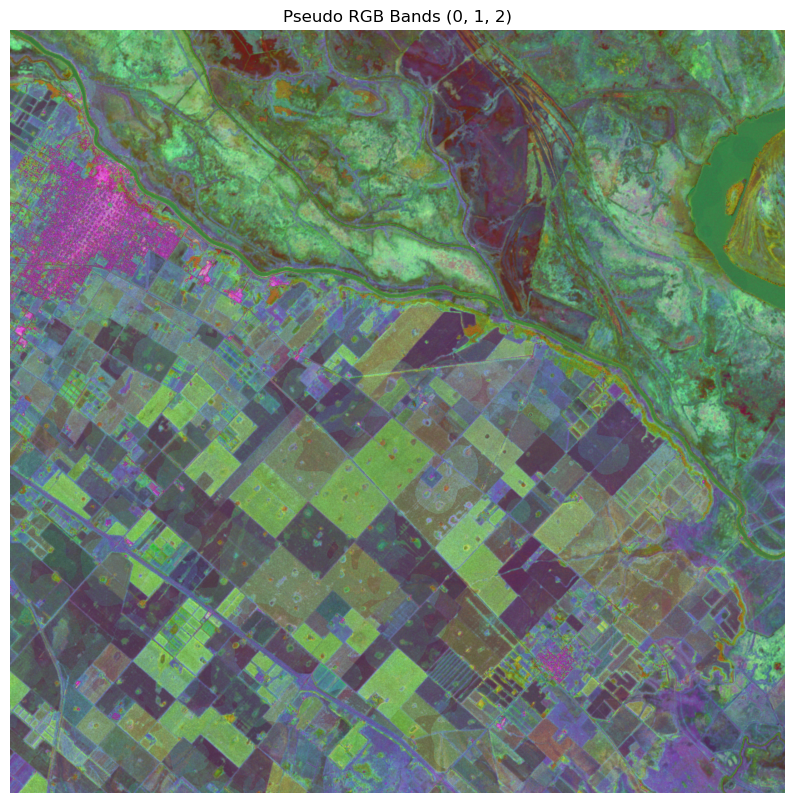

In [23]:
# Create a pseudo-RGB from three arbitrary embedding bands
pseudo_indices = (0, 1, 2) if data.shape[0] >= 3 else None
if pseudo_indices:
    pseudo = data[list(pseudo_indices), :, :].astype(float)
    # Normalize each selected band individually
    for i in range(3):
        b = pseudo[i]
        pseudo[i] = (b - b.min()) / (b.max() - b.min() + 1e-9)
    rgb = np.transpose(pseudo, (1, 2, 0))
    plt.figure(figsize=(10,10))
    plt.imshow(rgb)
    plt.title(f'Pseudo RGB Bands {pseudo_indices}')
    plt.axis('off')
    plt.show()
else:
    print("Not enough bands for pseudo-RGB composite.")

## 5. Next Steps
You can now:
- Feed embeddings into clustering or dimensionality reduction for pattern discovery.
- Sample embeddings at reference points for model training.
- Compare embeddings across seasons or AOIs.
- ...